# A background elimination method based on linear programming for Raman spectra 

In this notebook we are trying to reproduce the background elimination technique described in the article of Sung-June Baek, Aaron Park, Aigou Shen, Jiming Hu: https://doi.org/10.1016/j.chemolab.2009.04.007.

### Settings and functions

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import linprog
%matplotlib inline
font = {'size': 15}

In [4]:
def raman_plot():
    """
    Funzione che serve per settare la dimensione dell'immgine e i label degli assi per un plot di spettro Raman.
    """
    plt.figure(figsize=(16,6))
    plt.xlabel(r"Raman shift [$cm^{-1}$]",fontsize=18)
    plt.ylabel("Intensity [a.u.]",fontsize=18)

In [5]:
def define_names(r=11,c=11):
    """
    Funzione che definisce i nomi delle coordinate degli spettri sul sample. I nomi sono del tipo r1c1,r1c2, ecc.
    Come default usa 11 colonne e 11 righe. Il primo nome è wn, che sta per wave number.
    """
    #definisco i nomi da assegnare ai punti delli spettri di sampling
    #wn -> wave number  r -> row c -> columns
    names = ['wn']+[f'r{k}c{i}' for k in range(1,r+1) for i in range(1,c+1)]
    return names

In [6]:
def interpol(S):
    min = int(S[0][0]) if S[0][0]==0 else int(S[0][0]) +1
    max = int(S[0][-1])
    X = np.arange(min,max+1,1)
    S = np.array([X, np.interp(X,S[0],S[1])])
    return S

In [7]:
def _raman_labels():
    plt.figure(figsize=(10,5))
    plt.xlabel(r'Raman shift [$cm^{-1}$]')
    plt.ylabel('Counts')

def plot(S):
    S = type2spectra(S)
    _raman_labels()
    if type(S)!=list:
        plt.plot(S[0], S[1])
    else:
        for s in S:
            plt.plot(s[0], s[1], label='')
    plt.show(block=False)

## Import of some test spectra
Here we import a few spectra on which to test this background-elimination technique. Then we chose one among these in the variable *col* on which the procedure is performed, change that variable to change the test-spectrum.

In [8]:
# open txt file with numpy array
n=11

temp = np.loadtxt('./data/S1_mapA_11x11.txt')
wn = temp[:,0]
data = np.zeros((n,n,len(wn)))
for i in range(n):
    for j in range(n):
        data[i,j,:] = temp[:,1+i*n+j]

# The procedure

The first step is the spectrum interpolation. This is something we do for each used spectrum just for simplicity. As can be seen from the plot there is absolutely no differences in the shape of the original spectrum and the interpolated one.

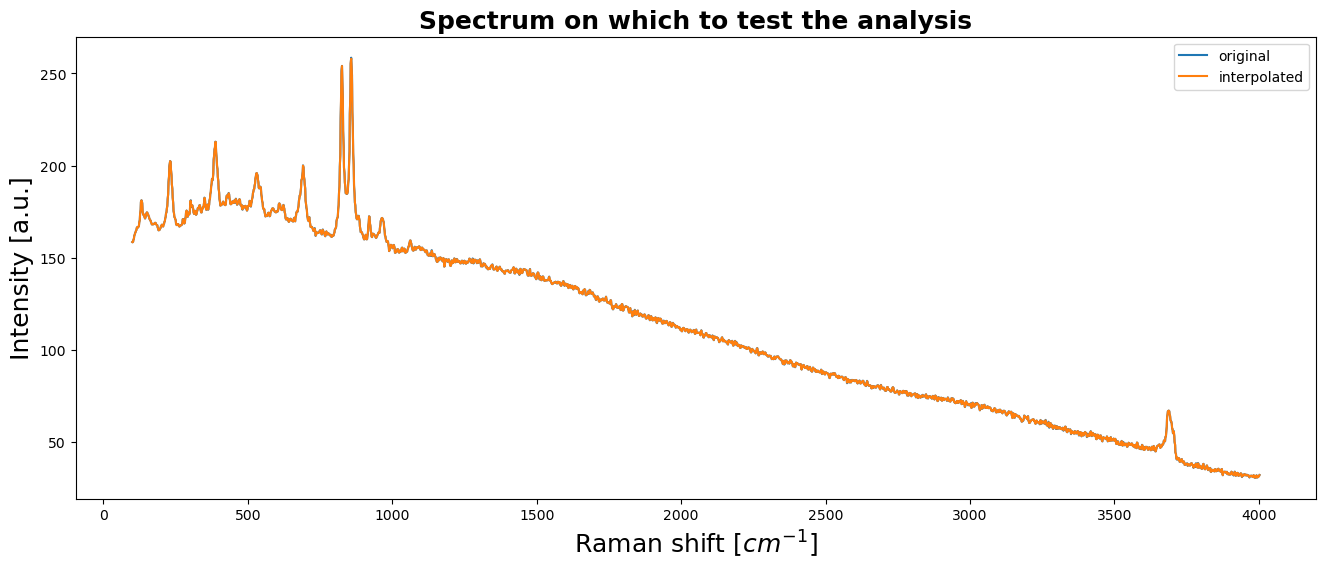

In [9]:
S = np.array([wn,data[10,10]])

raman_plot()
plt.plot(S[0],S[1], label = 'original')
S=interpol(S)
plt.plot(S[0],S[1], label = 'interpolated')
plt.title('Spectrum on which to test the analysis',fontsize=18,fontweight='bold')
plt.legend()

## Noise removal
Apply Savitzky–Golay ﬁlter with span $L_n$ to the given spectrum. The degree of a polynomial is set to 2. In the following, $s$ denotes the noise removed data. It doesn't matter if the peaks are distorted since we are interested in the background.

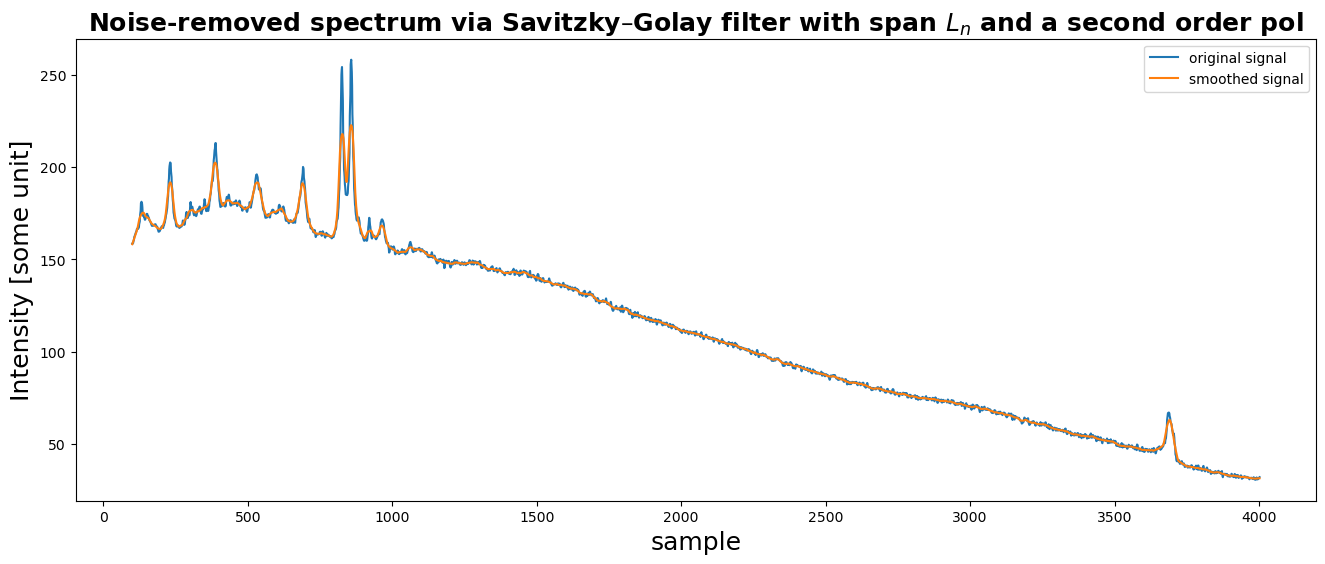

In [10]:
#############################################################################################
L_n=21                                       #lenght of smoothing filter for noise removal  #
pol_degree=1                                                                                 #
#############################################################################################
S_smooth = S.copy()
S_smooth[1]=savgol_filter(S[1],L_n,pol_degree)

plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("Intensity [some unit]",fontsize=18)
plt.title('Noise-removed spectrum via Savitzky–Golay filter with span $L_n$ and a second order pol',fontsize=18,fontweight='bold')
plt.plot(S[0],S[1], label='original signal')
plt.plot(S_smooth[0],S_smooth[1], label='smoothed signal')
plt.legend()

# Gaussian Kernel
Let's try to use gaussian functions instead of polynomial functions.

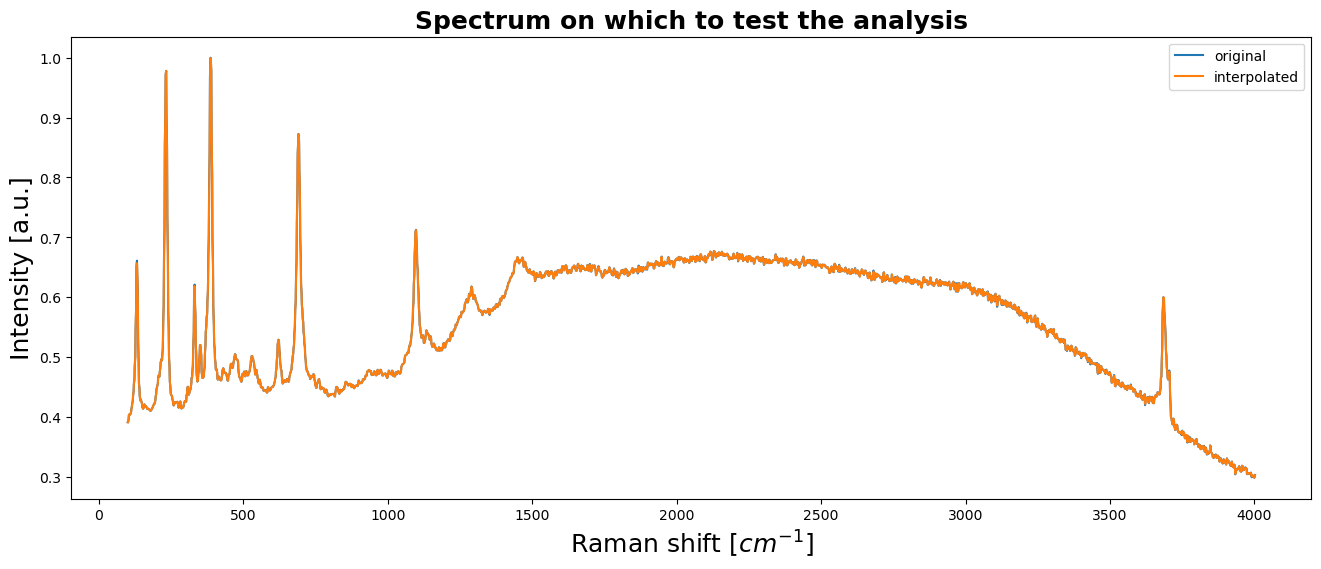

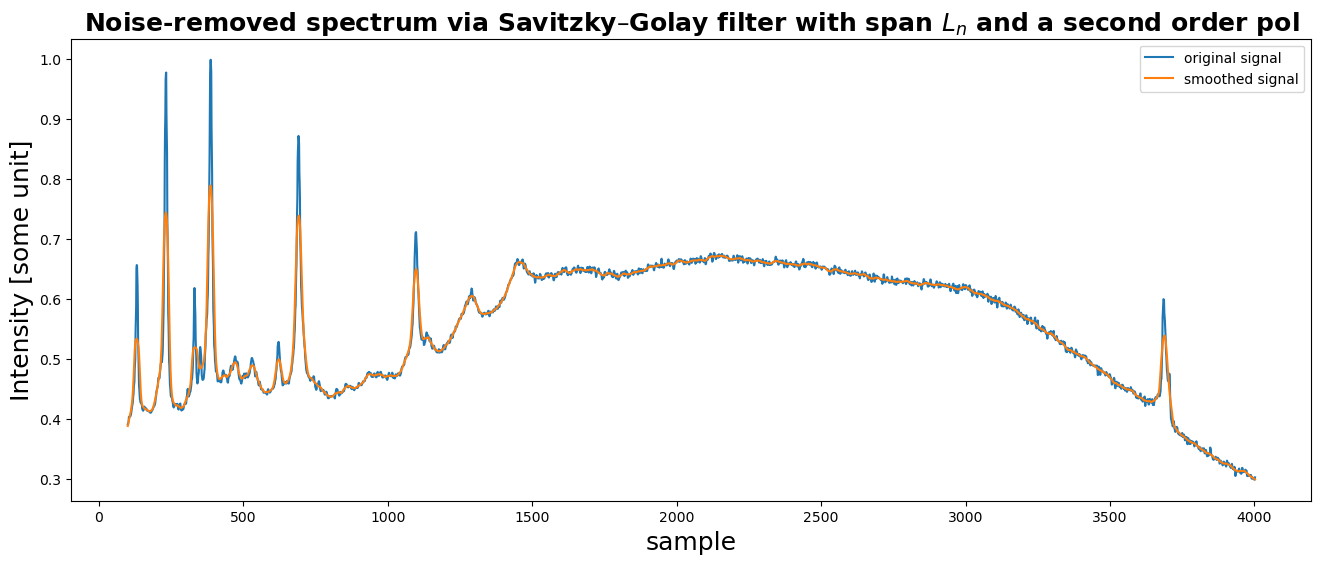

In [11]:
S = np.array([wn,data[5,6]])

S[1] = S[1]/np.max(S[1])
raman_plot()
plt.plot(S[0],S[1], label = 'original')
S=interpol(S)
plt.plot(S[0],S[1], label = 'interpolated')
plt.title('Spectrum on which to test the analysis',fontsize=18,fontweight='bold')
plt.legend()
#############################################################################################
L_n=21                                      #lenght of smoothing filter for noise removal  #                                                                                 #
#############################################################################################
S_smooth = S.copy()
S_smooth[1]=savgol_filter(S[1],L_n,1)

plt.figure(figsize=(16,6))
plt.xlabel("sample",fontsize=18)
plt.ylabel("Intensity [some unit]",fontsize=18)
plt.title('Noise-removed spectrum via Savitzky–Golay filter with span $L_n$ and a second order pol',fontsize=18,fontweight='bold')
plt.plot(S[0],S[1], label='original signal')
plt.plot(S_smooth[0],S_smooth[1], label='smoothed signal')
plt.legend()

## Fit with gaussian kernel

In [31]:
# GENERATIVE FUNCTION
def bkg_via_gauss(S, L_n, sigma, p, edge_width=1, edge_weight=1, plot=False):
   
   # smoothing
   S_smooth = S.copy()
   S_smooth[1]=savgol_filter(S[1],L_n,2)

   # matrice X
   X = np.zeros((len(S_smooth[0]),p))

   for i in enumerate(np.linspace(S_smooth[0,0]-sigma,S_smooth[0,-1]+sigma,p)):
      X[:, i[0]] = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(S_smooth[0]-i[1])**(2)/(2*sigma**2))
   
   # vector C
   H = np.concatenate((np.ones(edge_width)*edge_weight, np.ones(X.shape[0]-2*edge_width), np.ones(edge_width)*edge_weight))
   C = - np.dot(H,X)

   # solving the linear programming problem
   res = linprog(C, A_ub=X, b_ub = S_smooth[1], bounds = (-1e5, None), method='highs-ds')
   W = res['x']
   status = res['status'] # status = 0 means OK
   print('sum(Y-XW) = ', res['fun'])
   print('message = ', res['message'])
   print('# of iter = ', res['nit'])

   if status!=0:
      print('Fit failed !!!')
      return
   # generate the BKG

   BKG = np.array([S_smooth[0], np.dot(X,W)])
   S_nobkg = S.copy()
   S_nobkg[1] -= BKG[1]

   if plot==True:
      _raman_labels()
      plt.plot(BKG[0],BKG[1], label='Estimated background')
      plt.plot(S[0],S[1], label='Original signal')
      plt.plot(S_smooth[0],S_smooth[1], label='Smoothed signal')
      XX = np.arange(200,1000)
      plt.plot(XX, S[1,100]/2*(np.exp(-(XX-600)**(2)/(2*sigma**2))),label='Kernel function')
      plt.legend()
      plt.show()
   return S_nobkg, BKG

sum(Y-XW) =  -430402.1125934868
message =  Optimization terminated successfully. (HiGHS Status 7: Optimal)
# of iter =  242


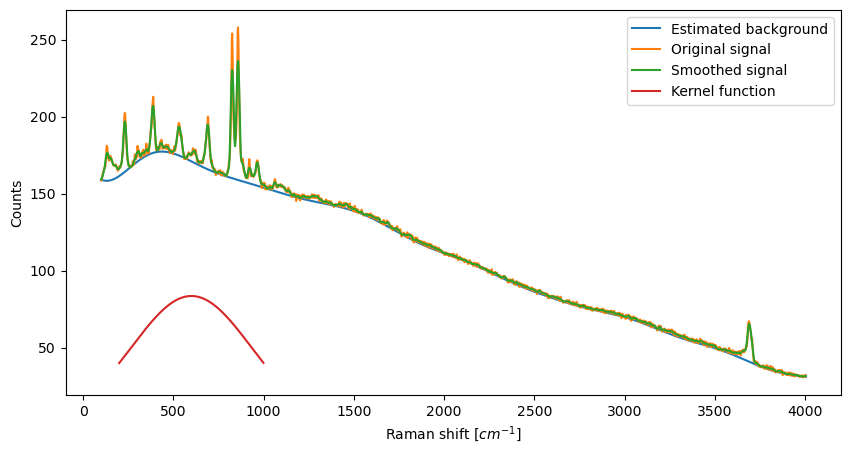

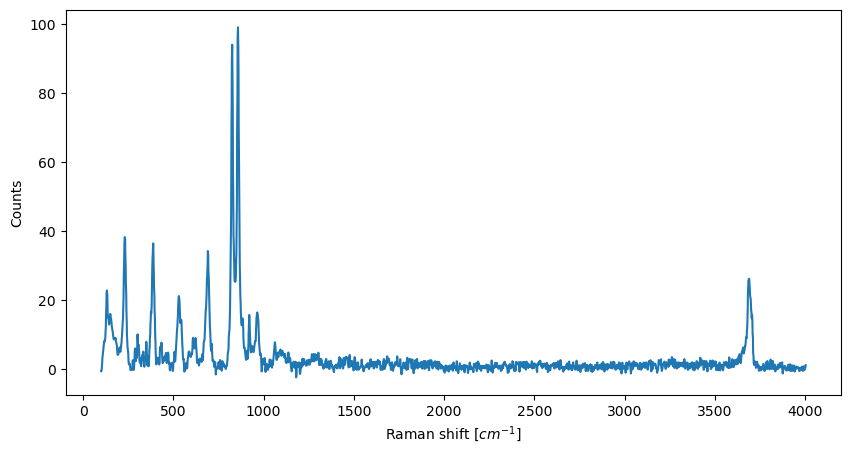

In [32]:
S = np.array([wn,data[10,10]])
S = interpol(S)

S_nobkg, BKG = bkg_via_gauss(S=S, L_n=31, sigma=330, p=100, edge_width=10, edge_weight=5, plot=True)

_raman_labels()
plt.plot(S_nobkg[0],S_nobkg[1])

# TEST

sum(Y-XW) =  -1515184.9576742689
message =  Optimization terminated successfully.
# of iter =  255
sum(Y-XW) =  -1517551.440702681
message =  Optimization terminated successfully.
# of iter =  299
sum(Y-XW) =  -1512150.5030244284
message =  Optimization terminated successfully.
# of iter =  165


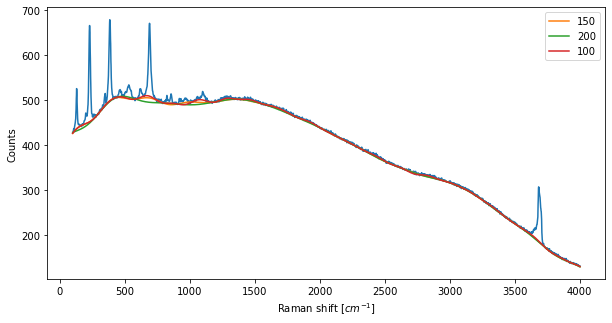

In [61]:
S_nobkg150, BKG150 = bkg_via_gauss(S=S, L_n=31, sigma=150, p=100)
S_nobkg100, BKG100 = bkg_via_gauss(S=S, L_n=31, sigma=100, p=100)
S_nobkg200, BKG200 = bkg_via_gauss(S=S, L_n=31, sigma=200, p=100)
_raman_labels()
plt.plot(S[0],S[1])
plt.plot(BKG150[0],BKG150[1], label='150')
plt.plot(BKG200[0],BKG200[1], label='200')
plt.plot(BKG100[0],BKG100[1], label='100')
plt.legend()


# Let's see lots of samples

sum(Y-XW) =  -386197.29584741674
message =  Optimization terminated successfully.
# of iter =  238
sum(Y-XW) =  -1017601.3398702703
message =  Optimization terminated successfully.
# of iter =  234
sum(Y-XW) =  -395323.9425094225
message =  Optimization terminated successfully.
# of iter =  221
sum(Y-XW) =  -440240.09236971504
message =  Optimization terminated successfully.
# of iter =  218
sum(Y-XW) =  -1047644.9032472653
message =  Optimization terminated successfully.
# of iter =  241
sum(Y-XW) =  -433692.3975134666
message =  Optimization terminated successfully.
# of iter =  223
sum(Y-XW) =  -615793.1324783012
message =  Optimization terminated successfully.
# of iter =  248
sum(Y-XW) =  -380428.8832663415
message =  Optimization terminated successfully.
# of iter =  215
sum(Y-XW) =  -517880.73792987596
message =  Optimization terminated successfully.
# of iter =  259
sum(Y-XW) =  -302904.44824847084
message =  Optimization terminated successfully.
# of iter =  214
sum(Y-XW) =  -

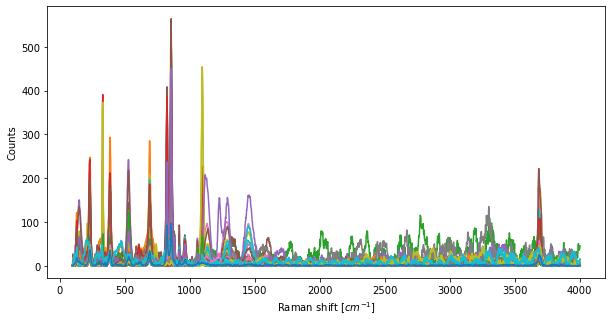

In [121]:
plt.figure(figsize=(10,5))
plt.xlabel(r'Raman shift [$cm^{-1}$]')
plt.ylabel('Counts')

for i in range(11):
    for j in range(11):
        
        S = np.array([wn,data[i,j]])
        
        S_nobkg, BKG = bkg_via_gauss(S=S,L_n=21,sigma=150,p=100,plot=False)

        for k in range(len(S_nobkg[1])):
            if S_nobkg[1][k]<0:
                S_nobkg[1][k]=0

        plt.plot(S_nobkg[0],S_nobkg[1])
        #plt.xlim(0,1700)
